In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
import torch
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import random
import argparse
import os
from PIL import Image
import cv2
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg 
import math
from os import listdir
from os.path import join


## Reading & Resizing Coco Dataset

In [21]:
TRAIN_PATH = Path("/Users/ivettesulca/Desktop/Project/Dataset_coco/train2014")
TRAIN_OUTPATH = Path("/Users/ivettesulca/Desktop/Project/Dataset_coco/n_train2014")

VAL_PATH = Path("/Users/ivettesulca/Desktop/Project/Dataset_coco/val2014")
#VAL_OUTPATH = Path("/Users/ivettesulca/Desktop/Project/Dataset_coco/n_val2014")

In [27]:
len(list(TRAIN_OUTPATH.iterdir()))

82784

In [25]:
! ls /Users/ivettesulca/Desktop/Project/Dataset_coco/n_train2014 | head

COCO_train2014_000000000077.jpg
COCO_train2014_000000000089.jpg
COCO_train2014_000000000260.jpg
COCO_train2014_000000000263.jpg
COCO_train2014_000000000315.jpg
COCO_train2014_000000000471.jpg
COCO_train2014_000000000659.jpg
COCO_train2014_000000000670.jpg
COCO_train2014_000000000671.jpg
COCO_train2014_000000000673.jpg


In [5]:
def read_image(path):
    im = mpimg.imread(path) 
    return im

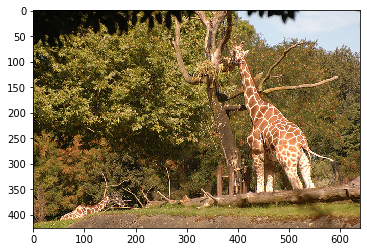

In [24]:
path = TRAIN_PATH/"COCO_train2014_000000000025.jpg"
im = read_image(path)
plt.imshow(im)

In [7]:
im.shape  # R,G,B

(426, 640, 3)

In [19]:
def crop(im, r, c, target_r, target_c): return im[r:r+target_r, c:c+target_c]

def center_crop_square(im):
    """ Returns a center crop of an image"""
    r,c,*_ = im.shape
    min_sz = min(r,c)
    start_r = math.ceil((r-min_sz)/2)
    start_c = math.ceil((c-min_sz)/2)
    return crop(im, start_r, start_c, min_sz, min_sz)

def get_a_crop(path, sz=250):
    im = cv2.imread(str(path))
    return cv2.resize(center_crop_square(im), (sz, sz))

def resize_all_images(input_path, output_path):
    
    input_path_str = str(input_path)
    for i,f in enumerate(os.listdir(input_path_str)):
       
        if f=='.DS_Store': continue
        
        img = get_a_crop(input_path_str+"/"+f)
        out_path_str = str(output_path) + "/"+f

        cv2.imwrite(out_path_str, img)
        
        if i%1000==0:
            print(f"Processed {i} images")
            print(out_path_str)


In [26]:
resize_all_images(TRAIN_PATH, TRAIN_OUTPATH)

Processed 0 images
/Users/ivettesulca/Desktop/Project/Dataset_coco/n_train2014/COCO_train2014_000000223373.jpg
Processed 1000 images
/Users/ivettesulca/Desktop/Project/Dataset_coco/n_train2014/COCO_train2014_000000376831.jpg
Processed 2000 images
/Users/ivettesulca/Desktop/Project/Dataset_coco/n_train2014/COCO_train2014_000000254925.jpg
Processed 3000 images
/Users/ivettesulca/Desktop/Project/Dataset_coco/n_train2014/COCO_train2014_000000118572.jpg
Processed 4000 images
/Users/ivettesulca/Desktop/Project/Dataset_coco/n_train2014/COCO_train2014_000000408151.jpg
Processed 5000 images
/Users/ivettesulca/Desktop/Project/Dataset_coco/n_train2014/COCO_train2014_000000198560.jpg
Processed 6000 images
/Users/ivettesulca/Desktop/Project/Dataset_coco/n_train2014/COCO_train2014_000000561126.jpg
Processed 7000 images
/Users/ivettesulca/Desktop/Project/Dataset_coco/n_train2014/COCO_train2014_000000214641.jpg
Processed 8000 images
/Users/ivettesulca/Desktop/Project/Dataset_coco/n_train2014/COCO_trai

Processed 72000 images
/Users/ivettesulca/Desktop/Project/Dataset_coco/n_train2014/COCO_train2014_000000347167.jpg
Processed 73000 images
/Users/ivettesulca/Desktop/Project/Dataset_coco/n_train2014/COCO_train2014_000000184190.jpg
Processed 74000 images
/Users/ivettesulca/Desktop/Project/Dataset_coco/n_train2014/COCO_train2014_000000156405.jpg
Processed 75000 images
/Users/ivettesulca/Desktop/Project/Dataset_coco/n_train2014/COCO_train2014_000000546620.jpg
Processed 76000 images
/Users/ivettesulca/Desktop/Project/Dataset_coco/n_train2014/COCO_train2014_000000296698.jpg
Processed 77000 images
/Users/ivettesulca/Desktop/Project/Dataset_coco/n_train2014/COCO_train2014_000000197853.jpg
Processed 78000 images
/Users/ivettesulca/Desktop/Project/Dataset_coco/n_train2014/COCO_train2014_000000370082.jpg
Processed 79000 images
/Users/ivettesulca/Desktop/Project/Dataset_coco/n_train2014/COCO_train2014_000000399581.jpg
Processed 80000 images
/Users/ivettesulca/Desktop/Project/Dataset_coco/n_train20

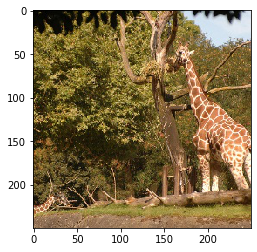

In [10]:
# Testing
path = TRAIN_OUTPATH/"COCO_train2014_000000000025.jpg"
im = read_image(path)
plt.imshow(im)

In [12]:
im.shape

(250, 250, 3)

## Creating Dataloaders

In [39]:
def normalize(im):
    """Normalizes images with Imagenet stats."""
    imagenet_stats = np.array([[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]])
    return (im - imagenet_stats[0])/imagenet_stats[1]

class CocoDataset(Dataset):
    def __init__(self, path, captions_json, vocab, transforms=False):

        self.path_to_images = path
        self.transforms = transforms        
        self.files = list((path).iterdir())        
        self.captions_json = captions_json
        
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, idx):
        path = str(self.files[idx]) 
        x = cv2.imread(str(path)).astype(np.float32)
        x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)/255
#         if self.transforms:
#             rdeg = (np.random.random()-.50)*20
#             x = rotate_cv(x, rdeg)
#             x = random_crop(x)
#             if np.random.random() > 0.5: x = np.fliplr(x).copy()
#         else:
#             x = center_crop(x)
        x = normalize(x)
        return np.rollaxis(x, 2) #, self.y[idx]

In [40]:
train_ds = CocoDataset(TRAIN_OUTPATH,None,None,False)

In [41]:
len(train_ds)

82784

In [42]:
batch_size = 5
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
#valid_dl = DataLoader(valid_ds, batch_size=batch_size)

In [43]:
x = train_ds[0]
x.shape

(3, 250, 250)